# Packages and libraries

In [1]:
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics


# Training with Transformers for Time series

Sentiments included

In [2]:
#eth = pd.read_csv('..\Data\Training\Ethereum.csv')
#ada = pd.read_csv('..\Data\Training\Cardano.csv')
#dot = pd.read_csv('Data\Training\Polkadot.csv')
eth = pd.read_csv('Ethereum.csv')
ada = pd.read_csv('Cardano.csv')
dot = pd.read_csv('Polkadot.csv')

In [3]:
eth

,dates,sentiment,pre_volu_eth,close_eth,previous_close_eth
0,1/2/2021,0.129833,0.197408,0.774535,0.975508
1,1/3/2021,0.233337,0.452005,0.975508,1.040233
2,1/4/2021,0.490335,0.569460,1.040233,1.100006
3,1/5/2021,0.503548,0.415359,1.100006,1.207112
4,1/6/2021,0.567268,0.446999,1.207112,1.225678
...,...,...,...,...,...
725,12/28/2022,0.526710,0.499167,1.189986,1.201595
726,12/29/2022,0.458966,0.413223,1.201595,1.199233
727,12/30/2022,0.517215,0.405567,1.199233,1.196771
728,12/31/2022,0.495758,0.301851,1.196771,1.200965


In [4]:
correlation_eth_ada = 0.9
correlation_eth_dot = 0.88

In [5]:
# Calculate denormalization factor
denormalization_factor = 1000
print("Denormalization Factor:", denormalization_factor)

Denormalization Factor: 1000


In [6]:
data = eth

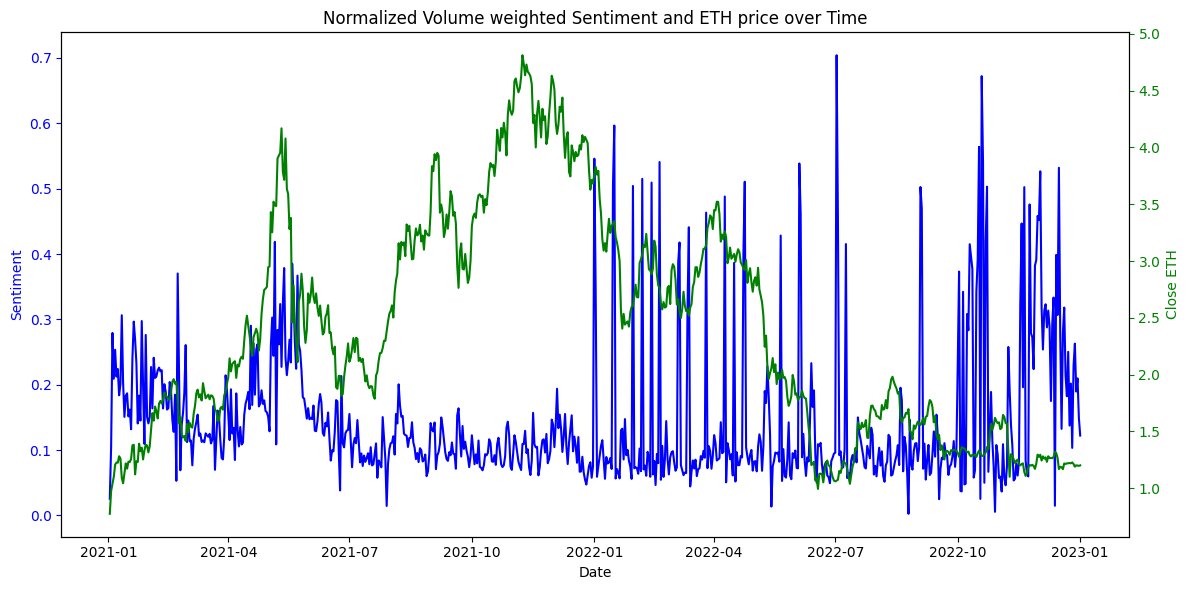

In [7]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing 'dates', 'sentiment', 'pre_volu_eth', and 'close_eth'
# Make sure 'dates' is in datetime format
data['dates'] = pd.to_datetime(data['dates'])

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sentiment on the left y-axis
ax1.plot(data['dates'], data['sentiment']*data["pre_volu_eth"], label='Sentiment', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second y-axis for close_eth on the right
ax2 = ax1.twinx()
ax2.plot(data['dates'], data['close_eth'], label='Close ETH', color='green')
ax2.set_ylabel('Close ETH', color='green')
ax2.tick_params('y', colors='green')

# Add title and legend
plt.title('Normalized Volume weighted Sentiment and ETH price over Time')
fig.tight_layout()
plt.show()

In [8]:
eth.head(2)

,dates,sentiment,pre_volu_eth,close_eth,previous_close_eth
0,2021-01-02,0.129833,0.197408,0.774535,0.975508
1,2021-01-03,0.233337,0.452005,0.975508,1.040233


In [9]:
eth["dates"] = pd.to_datetime(eth["dates"])
eth = eth.sort_values(by="dates")

In [10]:
#drop dates after sorting
dates = eth["dates"][-136:]
eth = eth.drop(["dates"],axis =1)

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(eth, test_size=0.20, shuffle=False)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


Y_train = df_train['close_eth'].tolist()
Y_test = df_test['close_eth'].tolist()

X_train = df_train.drop("close_eth",axis=1)
X_test = df_test.drop("close_eth",axis=1)

print("Training set has {} observations.".format(len(X_train)))
print("Test set has {} observations.".format(len(X_test)))

Training set has 584 observations.
Test set has 146 observations.


In [12]:
def to_sequences(seq_size, X, y):
    x_seq = []
    y_seq = []

    for i in range(len(X)-SEQUENCE_SIZE):
        window = X[i:(i+SEQUENCE_SIZE)].values
        after_window = y[i+5]
        window = [[x_seq] for x_seq in window]
        #print("{} - {}".format(window,after_window))
        x_seq.append(window)
        y_seq.append(after_window)

    return np.array(x_seq),np.array(y_seq)

In [13]:
SEQUENCE_SIZE = 10
X_train,y_train = to_sequences(SEQUENCE_SIZE,X_train,Y_train)
X_test,y_test = to_sequences(SEQUENCE_SIZE,X_test,Y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3]))

print("Shape of training set: {}".format(X_train.shape))
print("Shape of test set: {}".format(X_test.shape))

Shape of training set: (574, 10, 3)
Shape of test set: (136, 10, 3)


In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [15]:
def build_model(input_shape,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0,mlp_dropout=0,):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [16]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

In [17]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Epoch 1/200
8/8 [==============================] - 16s 268ms/step - loss: 8.6427 - val_loss: 3.9013
Epoch 2/200
8/8 [==============================] - 1s 174ms/step - loss: 8.4168 - val_loss: 3.8292
Epoch 3/200
8/8 [==============================] - 1s 164ms/step - loss: 8.2402 - val_loss: 3.7264
Epoch 4/200
8/8 [==============================] - 1s 167ms/step - loss: 8.1487 - val_loss: 3.5999
Epoch 5/200
8/8 [==============================] - 1s 160ms/step - loss: 8.1684 - val_loss: 3.4537
Epoch 6/200
8/8 [==============================] - 2s 254ms/step - loss: 7.9021 - val_loss: 3.2981
Epoch 7/200
8/8 [==============================] - 2s 260ms/step - loss: 7.4989 - val_loss: 3.1344
Epoch 8/200
8/8 [==============================] - 1s 172ms/step - loss: 7.4537 - val_loss: 2.9489
Epoch 9/200
8/8 [==============================] - 1s 176ms/step - loss: 7.0186 - val_loss: 2.7419
Epoch 10/200
8/8 [==============================] - 1s 174ms/step - loss: 6.9572 - val_loss: 2.5231
Epoch 11

0.10790406167507172

In [18]:
pred = model.predict(X_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

5/5 [==============================] - 1s 24ms/step
Score (RMSE): 0.32848752589415664


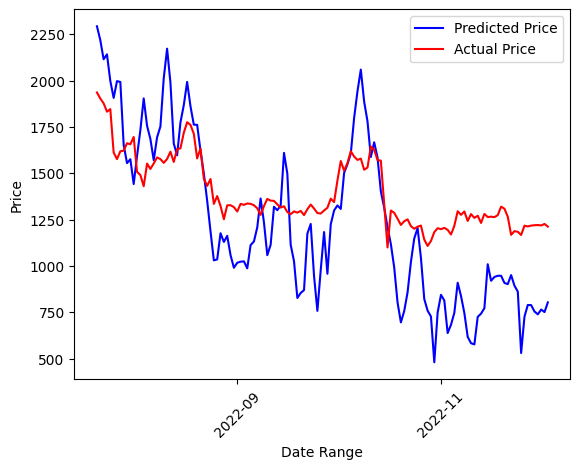

In [19]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import numpy as np

# Plot predicted and actual prices
plt.plot(dates, pred * 1000, label='Predicted Price', color='b')
plt.plot(dates, y_test * 1000, label='Actual Price', color='red')

plt.xlabel('Date Range')
plt.ylabel('Price')
plt.legend()

# Show dates after every two months
plt.gca().xaxis.set_major_locator(MonthLocator(bymonthday=-1, interval=2))

# Rotate x-axis labels for better presentation
plt.xticks(rotation=45)

plt.show()

In [24]:
predicted = pd.DataFrame(pred,columns=["values"])
predicted["dates"] = np.array(dates)
predicted.to_csv("Sentiments+SynEthprices.csv")